In [1]:
from nilearn import image
from nilearn import plotting
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

ModuleNotFoundError: No module named 'nilearn'

In [2]:
import os
class MRIHandler():
    INPUT_SHAPE = (320, 320, 80)
    LAST_CHANNEL_NO = INPUT_SHAPE[2]

    IMG_PATH = "imagesTr/"
    LABEL_PATH = "labelsTr/"

    def __init__(self):

        self.paths_to_all_imgs = self._create_path_list(self.IMG_PATH)
        self.paths_to_all_labels = self._create_path_list(self.LABEL_PATH)
        self.batch_size = 2
        self.classes = 2

    def next_batch(self, batch_size=2):
        self.batch_size = batch_size
        ind = np.random.choice(self.paths_to_all_imgs, batch_size)
        imgs, labels = self._load_batch(ind)
        label_mask = self._create_one_hot_label(labels)
        return imgs, label_mask, labels

    def _load_batch(self, ind):
        imgs = []
        labels = []
        for i in ind:
            s = i.split("/")
            img = image.smooth_img(i, None).get_data()[:,:,:self.LAST_CHANNEL_NO]
            imgs.append(img)
            
            label_path_name = f'labelsTr/{s[1]}'
            label = image.smooth_img(label_path_name, None).get_data()[:,:,:self.LAST_CHANNEL_NO]
            labels.append(label)
        return np.expand_dims(np.array(imgs),-1), np.array(labels)

    def _create_one_hot_label(self, label_mask):
        mask = np.zeros((self.batch_size, self.INPUT_SHAPE[0], self.INPUT_SHAPE[1],self.INPUT_SHAPE[2],
                         self.classes))

        for c in range(self.batch_size):
            actual_label_mask = label_mask[c]
            for i in range(self.classes):
                equal = np.equal(actual_label_mask, i)
                mask[c, :, :,:, i] = equal

        return mask

    def _create_path_list(self, path):
        return_list = []
        for i in os.listdir(path):
            temp_path = os.path.join(path, i)
            return_list.append(temp_path)
        return return_list
    
    def load_val_data(self, val_path):
        imgs = []
        labels = []
        val_path_imgs = os.path.join(val_path, "imgs")
        val_path_labels = os.path.join(val_path, "labels")
        
        for i in os.listdir(val_path_imgs):
            img_path = os.path.join(val_path_imgs, i)
            img = image.smooth_img(img_path, None).get_data()[:,:,:self.LAST_CHANNEL_NO]
            imgs.append(img)
            
            label_path = os.path.join(val_path_labels, i)
            label = image.smooth_img(label_path, None).get_data()[:,:,:self.LAST_CHANNEL_NO]
            labels.append(label)
        return np.expand_dims(np.array(imgs), -1), np.array(labels)

            


In [3]:
class SegNetBasic:
    INPUT_SHAPE = [320, 320, 80]

    def __init__(self, no_classes):
        self.classes = no_classes

    def predict(self, data, is_training):

        d1 = self._decoder_block(data, 16, is_training)
        print(d1)
        d2 = self._decoder_block(d1, 16, is_training)
        print(d2)
        d3 = self._decoder_block(d2, 32, is_training)
        print(d3)
        d4 = self._decoder_block(d3, 32, is_training)
        print(d4)

        e1 = self._encoder_block(d4, 32, is_training)
        e2 = self._encoder_block(e1, 16, is_training)
        e3 = self._encoder_block(e2, 16, is_training)
        e4 = self._encoder_block(e3, self.classes, is_training)

        return e4

    def loss(self, image, mask):
        class_weight = tf.constant([0.01, 1])
        logits = tf.multiply(image, class_weight)
        print(logits)
        recon_error = tf.nn.softmax_cross_entropy_with_logits(labels=mask, logits=image)
        print(recon_error)

        cost = tf.reduce_mean(recon_error)
        return cost

    def optimizer(self, lr=1e-5):
        return tf.train.AdamOptimizer(learning_rate=lr)

    def _decoder_block(self, data, no_filters, is_training):
        l1 = tf.layers.conv3d(data, no_filters, [3, 3, 3], padding="same")
        m1 =  tf.layers.max_pooling3d(l1, [2,2,2], [2,2,2], padding="same")
        o1 = tf.nn.relu(m1)
        return o1

    def _encoder_block(self, data, no_filters, is_training):
        u1 = tf.layers.conv3d_transpose(data, no_filters, kernel_size=[7,7,7], strides=[2,2,2], padding="same")

        return u1

    

def create_prediction_and_label(prediction):
    values = np.argmax(prediction, axis=4)
    values = np.expand_dims(values, 4)
    return values


def pixel_accuracy(prediction, mask, no_classes=2):
    prediction = np.squeeze(prediction, axis=4)
    sum = 0
    target_sum = np.size(mask)

    for i in range(no_classes):
        target = (mask == i)
        pred = (prediction == i)
        correct_pixels = np.logical_and(target, pred)

        if not np.sum(target) == 0:
            sum += np.sum(correct_pixels) / target_sum

    return sum


In [4]:
tf.reset_default_graph()
import sys
sys.path.append("../")  # noqa
import tensorflow as tf

INPUT_SHAPE = [320, 320, 80]
MAX_CLASS = 2

logdir = "logs/training"
file_writer = tf.summary.FileWriter(logdir, flush_secs=5)
loss_feed = tf.placeholder(tf.float32)
pixel_acc_feed = tf.placeholder(tf.float32)
tensorboard_images = tf.placeholder(tf.float32, [None, INPUT_SHAPE[0], INPUT_SHAPE[1],INPUT_SHAPE[2], 1], name="Tensorboard_Images")
tensorboard_images_labels = tf.placeholder(tf.float32, [None, INPUT_SHAPE[0], INPUT_SHAPE[1],INPUT_SHAPE[2], 1], name="Tensorboard_Images_Labels")
tensorboard_inputs = tf.placeholder(tf.float32, [None, INPUT_SHAPE[0], INPUT_SHAPE[1],INPUT_SHAPE[2], 3], name="Inputs")
loss_summary = tf.summary.scalar("Loss", loss_feed)
pixel_acc_summary = tf.summary.scalar("Pixel_Acc", pixel_acc_feed)
img_summary = tf.summary.image("Predictions", tensorboard_images)
img_summary2 = tf.summary.image("Images", tensorboard_inputs)
img_summary3 = tf.summary.image("Labels", tensorboard_images_labels)


input_im = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2], 1], name="input")
mask = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2], MAX_CLASS], name="Segmentation")


segnet = SegNetBasic(2)
prediction = segnet.predict(input_im, is_training=True)
cost = segnet.loss(prediction, mask)
optimizer = segnet.optimizer(1e-5)
update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)

with tf.control_dependencies(update_ops):
    train_op = optimizer.minimize(cost)


saver = tf.train.Saver(max_to_keep=30)


dh = MRIHandler()
STEP = 3000
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver.restore(sess, f'checkpoints/model-{STEP}')
    for i in range(STEP, 6000):

        img_batch, label_batch, orig_labels = dh.next_batch(1)
        _, loss, pred = sess.run([train_op, cost, prediction], feed_dict={input_im: img_batch, mask: label_batch})
        print(loss)

        predicted_segmentation = create_prediction_and_label(pred)
        pixel_acc = pixel_accuracy(predicted_segmentation, orig_labels, MAX_CLASS)
        print(pixel_acc)

        if i % 10 != 0:
            summaries = [loss_summary, pixel_acc_summary]
            summary_op = tf.summary.merge(summaries)
            summary = sess.run(summary_op, feed_dict={loss_feed: loss,
                                                      pixel_acc_feed: pixel_acc})

            file_writer.add_summary(summary, i)

        if i % 10 == 0:
            
            img, label = dh.load_val_data("val/")
            pred = sess.run(prediction, feed_dict={input_im: np.expand_dims(img[0],0)})
            pred = create_prediction_and_label(pred)
            pred_sum = np.sum(pred)
            print(f'Ones in Pred:{pred_sum}')
            
            pixel_acc = pixel_accuracy(pred, label, MAX_CLASS)
            print(f'Val Pixel Acc:{pixel_acc}')


        if i % 100 == 0 and i > 0:
            saver.save(sess, "checkpoints/model", global_step=i)



Tensor("Relu:0", shape=(?, 160, 160, 40, 16), dtype=float32)
Tensor("Relu_1:0", shape=(?, 80, 80, 20, 16), dtype=float32)
Tensor("Relu_2:0", shape=(?, 40, 40, 10, 32), dtype=float32)
Tensor("Relu_3:0", shape=(?, 20, 20, 5, 32), dtype=float32)
Tensor("Mul:0", shape=(?, 320, 320, 80, 2), dtype=float32)
Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Tensor("softmax_cross_entropy_with_logits_sg/Reshape_2:0", shape=(?, 320, 320, 80), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/model-3000
0.0010607066
0.99958154296875
Ones in Pred:23568
Val Pixel Acc:0.9957038981119791
0.0012087831
0.9995358886718749
0.0006706059
0.999758056640625
0.0006697379
0.999711669921875
0.0012047758
0.999537353515625
0.00066895934
0.999711181640625
0.0006839815
0.9997164306640625
0.0009318819
0.99966064453125
0.0008396293
0.999662841796875
0.000929976

Ones in Pred:22901
Val Pixel Acc:0.9957412923177082
0.000893555
0.9996657714843751
0.0008234751
0.9996668701171875
0.001179555
0.9995421142578125
0.0008318845
0.999678955078125
0.0006316784
0.9997747802734375
0.0006761946
0.9997198486328125
0.0009111341
0.9996458740234375
0.0010008359
0.9996083984374999
0.00067538203
0.9997203369140626
0.00063517276
0.999729248046875
Ones in Pred:23093
Val Pixel Acc:0.9957291666666667
0.000908405
0.9996490478515625
0.0009987394
0.99960986328125
0.0008908804
0.999666259765625
0.0006340537
0.9997281494140624
0.0011432618
0.9995081787109376
0.0009953299
0.9996121826171875
0.0011767304
0.9995430908203125
0.00080799044
0.999693359375
0.00067144947
0.9997216796875
0.0008277899
0.9996820068359376
Ones in Pred:23140
Val Pixel Acc:0.9957258707682292
0.0008269519
0.9996827392578125
0.0008176726
0.9996652832031251
0.0006736715
0.9997171630859375
0.0011715546
0.9995450439453124
0.00082220515
0.99968505859375
0.00081718323
0.9996663818359375
0.00088877213
0.9996685

0.0010962238
0.9995860595703125
0.00065780745
0.9997254638671875
0.00096563157
0.9995871582031249
0.00095974054
0.9995915527343749
0.00063619
0.9997225341796875
0.0008126925
0.9996668701171876
0.0011075212
0.9995631103515625
Ones in Pred:22637
Val Pixel Acc:0.9957635091145833
0.0008510908
0.999675048828125
0.0006256059
0.99977099609375
0.00085034524
0.99967529296875
0.0009684237
0.9996231689453124
0.0007809514
0.9997008056640625
0.00091236073
0.9996279296875
0.0008105193
0.99966796875
0.0010925452
0.9995887451171874
0.0006581861
0.9997244873046875
0.00063232065
0.9997252197265625
Ones in Pred:22728
Val Pixel Acc:0.9957587483723959
0.0006572798
0.9997252197265625
0.00083176885
0.9996568603515624
0.00089318055
0.999645751953125
0.0007870025
0.99969921875
0.00062940386
0.9997276611328125
0.0007866628
0.9997000732421875
0.00082635065
0.999657470703125
0.00084642775
0.99968017578125
0.00080134295
0.9996748046875
0.00082169694
0.9996575927734375
Ones in Pred:22907
Val Pixel Acc:0.99574796549

0.0006302264
0.9997358398437499
0.0006355228
0.999739990234375
Ones in Pred:23871
Val Pixel Acc:0.9956882324218751
0.00076012826
0.99971044921875
0.0006293795
0.9997343750000001
0.00089433545
0.9996380615234375
0.0010474629
0.9996070556640625
0.0007665339
0.9996844482421875
0.0008377734
0.9996831054687499
0.0010965148
0.9995635986328125
0.0008342351
0.9996834716796875
0.0006352873
0.99973876953125
0.000830138
0.99968359375
Ones in Pred:23467
Val Pixel Acc:0.9957087402343751
0.0008279491
0.9996844482421875
0.0009239029
0.9996378173828125
0.001042541
0.9996092529296875
0.0011909312
0.9994752197265625
0.000776213
0.9996824951171875
0.000629857
0.999741943359375
0.00074341276
0.9997202148437501
0.0009872549
0.999560302734375
0.00062310253
0.9997386474609375
0.00075605034
0.999690185546875
Ones in Pred:23149
Val Pixel Acc:0.9957263997395833
0.0006281319
0.9997420654296875
0.00078482844
0.9996798095703125
0.0010449033
0.9996038818359375
0.001044702
0.9996038818359375
0.00091295806
0.99964550

0.0010046657
0.99962255859375
0.00075596594
0.999688720703125
0.0007264143
0.999724853515625
0.00075527525
0.9996883544921875
0.00086624216
0.999666748046875
0.00079627143
0.9996888427734375
0.0006027286
0.99975146484375
0.00060542417
0.9997415771484375
0.0010074372
0.9995501708984375
0.00081100606
0.99967626953125
Ones in Pred:22841
Val Pixel Acc:0.9957489420572917
0.0010442479
0.9995830078125001
0.00062946475
0.9997371826171875
0.00097184465
0.9995748291015625
0.000587282
0.9997855224609374
0.00094669877
0.99959375
0.00063379435
0.99973583984375
0.0006270349
0.9997371826171875
0.0006276225
0.999736328125
0.0012962997
0.9994326171875001


KeyboardInterrupt: 

In [9]:
tf.reset_default_graph()
STEP = 3800
IMG_NO = 0
INPUT_SHAPE = [320, 320, 80]
input_im = tf.placeholder(dtype=tf.float32, shape=[None, INPUT_SHAPE[0], INPUT_SHAPE[1], INPUT_SHAPE[2], 1], name="input")

segnet = SegNetBasic(2)
prediction = segnet.predict(input_im, False)
saver = tf.train.Saver()
dh = MRIHandler()

with tf.Session() as sess:
    tf.global_variables_initializer()
    saver.restore(sess, f'checkpoints/model-{STEP}')
    img, label = dh.load_val_data("val/")
    #img, _, label = dh.next_batch(1)
    pred = sess.run(prediction, feed_dict={input_im: np.expand_dims(img[IMG_NO],0)})
    pred = create_prediction_and_label(pred)

Tensor("Relu:0", shape=(?, 160, 160, 40, 16), dtype=float32)
Tensor("Relu_1:0", shape=(?, 80, 80, 20, 16), dtype=float32)
Tensor("Relu_2:0", shape=(?, 40, 40, 10, 32), dtype=float32)
Tensor("Relu_3:0", shape=(?, 20, 20, 5, 32), dtype=float32)
INFO:tensorflow:Restoring parameters from checkpoints/model-3800


<IPython.core.display.Javascript object>


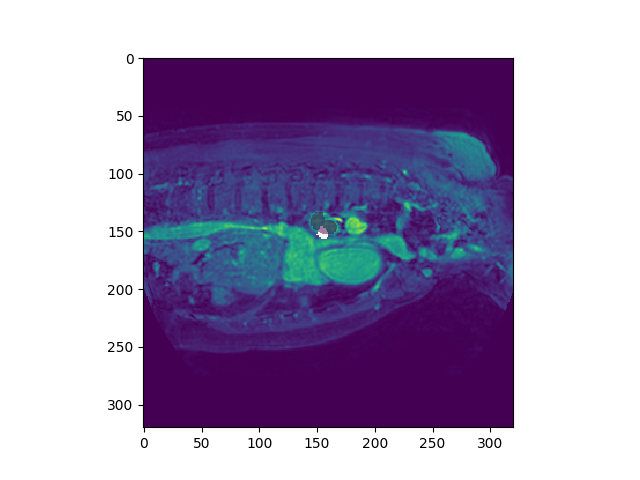

/home/marci/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  after removing the cwd from sys.path.
/home/marci/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:397: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/home/marci/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:398: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/home/marci/anaconda3/lib/python3.6/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/home/marci/anaconda3/lib/python3.6/site-packages/matplotlib/i

In [10]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
ax2 = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()
test_pred = pred*10
pred2 = np.ma.masked_where(test_pred == 0, test_pred)
orig = np.ma.masked_where(label == 0, label)

for i in range(80):
    ax.clear()
    ax.imshow(img[0,:,:,i,0])
    
    ax.imshow(pred2[0,:,:,i,0], alpha=1, cmap="Reds")
    ax.imshow(orig[IMG_NO,:,:,i], alpha=0.5)
    fig.canvas.draw()

In [ ]:
%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(80):
    ax.clear()
    ax.imshow(img[1,:,:,i,0])
    orig = np.ma.masked_where(label == 0, label)
    ax.imshow(orig[0,:,:,i], alpha=0.7, cmap="Reds")
    fig.canvas.draw()

In [34]:
def pixel_accuracy(prediction, mask, no_classes=2):
    prediction = np.squeeze(prediction, axis=4)
    sum = 0
    target_sum = np.sum((mask > 0))

    for i in range(1, no_classes):
        target = (mask == i)
        pred = (prediction == i)
        correct_pixels = np.logical_and(target, pred)

        if not np.sum(target) == 0:
            sum += np.sum(correct_pixels) / target_sum

    return sum



In [39]:
pred = np.array([[0, 1, 1], 
                [1, 1, 1]])
pred = pred.reshape(1, 2, 3, 1, 1)
mask = np.array([[1, 1, 1], 
                [1, 1, 1]])
mask = mask.reshape(1, 2, 3, 1)

In [40]:
pixel_accuracy(pred, mask)

0.8333333333333334

In [28]:
np.squeeze(pred, axis=4)

array([[[[1],
         [2],
         [3]],

        [[4],
         [5],
         [6]]]])

In [27]:
mask

array([[[[1],
         [2],
         [3]],

        [[4],
         [5],
         [6]]]])